# Replicating ResNet paper: Deep Residual Learning for Image Recognition

## Preparing the data

The data that will be used is ImageNet 100: (per class)
* 1300 **train** images
* 100 **val** images 


In [1]:
BATCH_SIZE = 1
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
train_dir = "archive/train.X"
val_dir   = "archive/val.X/"

import keras
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
)

In [4]:
val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 5000 files belonging to 100 classes.


In [23]:
class_names = train_ds.class_names
class_names[:10]

['n01440764',
 'n01443537',
 'n01484850',
 'n01491361',
 'n01494475',
 'n01496331',
 'n01498041',
 'n01514668',
 'n01514859',
 'n01531178']

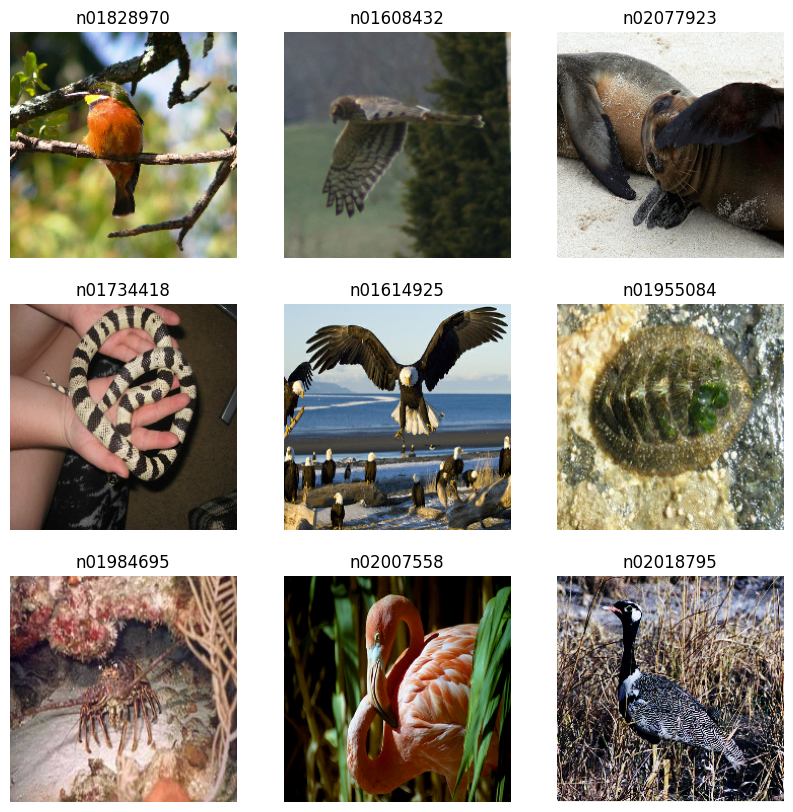

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [8]:
normalization_layer = keras.layers.Rescaling(1./255)

In [9]:
train_norm_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
val_norm_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
import numpy as np

image_batch, labels_batch = next(iter(train_norm_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
import tensorflow as tf
train_norm_ds = train_norm_ds.prefetch(tf.data.AUTOTUNE)
val_norm_ds = val_norm_ds.prefetch(tf.data.AUTOTUNE)

In [13]:
train_norm_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Building residual layer

In [14]:
import tensorflow as tf
import keras
from keras.layers import Dense, Input, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.activations import relu, softmax
from keras.optimizers import Adam
from keras.losses import mae

In [15]:
dummy_tensor = tf.range(-5, 5)
keras.activations.relu(dummy_tensor)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 1, 2, 3, 4], dtype=int32)>

In [16]:
class ResidualLayer(keras.layers.Layer):
    def __init__(self, list_neurons:list[int, int, int],  **kwargs):
        super().__init__(**kwargs)
        self.n_a, self.n_b, self.n_c = list_neurons

        self.conv2a = Conv2D(self.n_a, 1, activation='relu')
        self.norm_a = BatchNormalization()
        
        self.conv2b = Conv2D(self.n_b, 3, padding="same", activation='relu')
        self.norm_b = BatchNormalization()
        
        self.conv2c = Conv2D(self.n_c, 1, activation='relu')
        self.norm_c = BatchNormalization()

        self.conv2add = Conv2D(self.n_c, 1, padding="same", activation='relu')

    def call(self, inputs, training=False):
        x = self.conv2a(inputs)
        x = self.norm_a(x, training=training)
        x = relu(x)

        x = self.conv2b(x)
        x = self.norm_b(x, training=training)
        x = relu(x)

        x = self.conv2c(x)
        x = self.norm_c(x, training=training)
        
        # x += self.conv2add(inputs)

        return relu(x)

## Creating a 50-layer model

In [17]:
keras.backend.clear_session()

In [18]:
model_input = Input((224, 224, 3), dtype=tf.float32)

conv_2x = Conv2D(64, 7, strides=2, activation='relu')(model_input)
maxpool_x = MaxPooling2D((3, 3), strides=2)(conv_2x)

residual_1a = ResidualLayer([64, 64, 256], name="1_a")(maxpool_x)
residual_1b = ResidualLayer([64, 64, 256], name="1_b")(residual_1a)
residual_1c = ResidualLayer([64, 64, 256], name="1_c")(residual_1b)

residual_2a = ResidualLayer([128, 128, 512], name="2_a")(residual_1c)
residual_2b = ResidualLayer([128, 128, 512], name="2_b")(residual_2a)
residual_2c = ResidualLayer([128, 128, 512], name="2_c")(residual_2b)
residual_2d = ResidualLayer([128, 128, 512], name="2_d")(residual_2c)

residual_3a = ResidualLayer([256, 256, 1024], name="3_a")(residual_2d)
residual_3b = ResidualLayer([256, 256, 1024], name="3_b")(residual_3a)
residual_3c = ResidualLayer([256, 256, 1024], name="3_c")(residual_3b)
residual_3d = ResidualLayer([256, 256, 1024], name="3_d")(residual_3c)
residual_3e = ResidualLayer([256, 256, 1024], name="3_e")(residual_3d)
residual_3f = ResidualLayer([256, 256, 1024], name="3_f")(residual_3e)

residual_4a = ResidualLayer([512, 512, 2048], name="4_a")(residual_3f)
residual_4b = ResidualLayer([512, 512, 2048], name="4_b")(residual_4a)
residual_4c = ResidualLayer([512, 512, 2048], name="4_c")(residual_4b)

avg_pool    = AveragePooling2D(name="5")(residual_4c)
flatten      = Flatten()(avg_pool)
print(flatten.shape)
model_output = Dense(100, activation='softmax')(flatten)

print(model_output.shape)
model_50 = keras.Model(model_input, model_output)

(None, 1492992)
(None, 100)


In [19]:
model_50.compile(optimizer=Adam(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics="accuracy")

In [20]:
model_50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 109, 109, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 54, 54, 64)        0         
 D)                                                              
                                                                 
 1_a (ResidualLayer)         (None, 54, 54, 256)       59264     
                                                                 
 1_b (ResidualLayer)         (None, 54, 54, 256)       71552     
                                                                 
 1_c (ResidualLayer)         (None, 54, 54, 256)       71552     
                                                             

In [21]:
test_input = list(train_norm_ds.take(1))[0][0]
test_input.shape
test_output = list(train_norm_ds.take(1))[0][1]
test_output

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([91,  0, 32, 87, 43, 11, 94, 21,  4, 88,  1, 62, 79, 21,  3, 90, 77,
       81, 41, 23, 79, 16, 77, 61, 21, 70, 68, 11, 71, 53, 60,  0],
      dtype=int32)>

In [22]:
model_50.fit(test_input, test_output, epochs=10, verbose=1) #callbacks=[keras.callbacks.ReduceLROnPlateau(patience=100), keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)])

Epoch 1/10


2024-08-11 21:45:38.822772: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-11 21:45:38.889070: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-11 21:45:50.351587: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 91.12MiB (rounded to 95551488)requested by op model/1_b/batch_normalization_5/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-08-11 21:45:50.351713: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-08-11 21:45:50.351745: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 132, Chunks in use: 132. 33.0KiB allocated for chunks. 33.0

ResourceExhaustedError: Graph execution error:

Detected at node model/1_b/batch_normalization_5/FusedBatchNormV3 defined at (most recent call last):
  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_24799/711859886.py", line 1, in <module>

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/tmp/ipykernel_24799/1326631827.py", line 27, in call

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[32,256,54,54] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/1_b/batch_normalization_5/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_21172]

In [ ]:
# recompile
model_50.fit(train_norm_ds,
         epochs=GUESSSSS,
         validation_data=val_norm_ds,
         verbose=0,
         callbacks=[keras.callbacks.ReduceLROnPlateau(patience=100), 
                    keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)]))

In [23]:
model_50.evaluate(val_norm_ds)

1/1 [==============================] - 13s 13s/step - loss: 4.6052 - accuracy: 0.0000e+00


[4.6052045822143555, 0.0]

In [137]:
model_50.save("model_50.keras")

ValueError: Exception encountered when calling layer '1_2' (type ResidualLayer).

Input 0 of layer "conv2d_853" is incompatible with the layer: expected axis -1 of input shape to have value 256, but received input with shape (32, 224, 224, 3)

Call arguments received by layer '1_2' (type ResidualLayer):
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)
  • training=False

## ResNet-152

In [23]:
input_152 = Input((224, 224, 3))

conv2x = Conv2D(64, 7, strides=2)(input_152)
maxpool_x = MaxPooling2D((3, 3), strides=2)(conv2x)

residual = ResidualLayer([64, 64, 256], name="a_1")(maxpool_x)

for index in range(2):
    residual = ResidualLayer([64, 64, 256], name=f"a_{index+2}")(residual)

for index in range(8):
    residual = ResidualLayer([128, 128, 512], name=f"b_{index+1}")(residual)

for index in range(36):
    residual = ResidualLayer([256, 256, 1024], name=f"c_{index+1}")(residual)

for index in range(3):
    residual = ResidualLayer([512, 512, 2048], name=f"d_{index+1}")(residual)

avg_pool = AveragePooling2D(name="5")(residual)
flatten = Flatten()(avg_pool)
print(flatten.shape)
output_152 = Dense(100, activation='softmax')(flatten)

model_152 = keras.Model(input_152, output_152)

(None, 1492992)


In [24]:
model_152.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 64)      9472      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 a_1 (ResidualLayer)         (None, 54, 54, 256)       75904     
                                                                 
 a_2 (ResidualLayer)         (None, 54, 54, 256)       137344    
                                                                 
 a_3 (ResidualLayer)         (None, 54, 54, 256)       137344    
                                                           

In [25]:
model_152.compile(optimizer=Adam(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics="accuracy")

In [ ]:
# recompile
model_152.fit(train_norm_ds,
         epochs=GUESSSSS,
         validation_data=val_norm_ds,
         verbose=0,
         callbacks=[keras.callbacks.ReduceLROnPlateau(patience=100), 
                    keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)]))

In [ ]:
model_152.evaluate(val_norm_ds)

In [ ]:
model_152.save("model_152.keras")